**Lab 5: FIR Filtering 2**

The goal of this lab is to study the response of FIR filters to inputs such as complex exponentials and sinusoids. In the experiments of this lab, you will use `np.convolve()` to implement filters and `freqz()` to obtain the filter’s frequency response. As a result, you should learn how to characterize a filter by knowing how it reacts to different frequency components in the input.
This lab also introduces two practical filters: bandpass filters and nulling filters.
Bandpass filters can be used to detect and extract information from complex signals,
e.g., tones in a touch-tone telephone dialer. Nulling filters can be used to remove
sinusoidal interference, e.g., jamming signals in a radar.

In [6]:
import os
import numpy as np
import librosa
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt

from util import load_audio, plot_signals, plot_spectrogram, plot_mean_spectrogram

1.1. First, let's replicate what we did until now. Copy the functions synthesize and envelope and obtain the synthesis from the last lab.

In [19]:
import numpy as np
!git clone https://github.com/paablomorillo/sis1_group103.git
filepath = "./sis1_group103/audiosys.wav"
ref, fs = load_audio(filepath)
f0 = 350
T = 1 / 350
weights = [0.117, 1, 0.118, 0.126, 0.071, 0.012, 0.014, 0.01, 0.027, 0.016, 0.009, 0.0088, 0.006, 0.003, 0.0039, 0.0035, 0.0036, 0.0047, 0.0027, 0.0053, 0.0068, 0.011, 0.018, 0.02, 0.015, 0.02, 0.003]


def envelope(x, N):
    """
    Extracts the envelope of x by full-wave rectification followed by an N-point moving average.
    Output length matches input (mode='same').
    """
    # full-wave rectification
    xr = np.abs(x)                                           # |x[n]| [attached_file:1]
    # N-point averaging filter (FIR with N equal taps)
    b = np.ones(int(N), dtype=float) / float(N)              # coefficients sum to 1 [attached_file:1]
    y = np.convolve(xr, b, mode='same')                      # keep same length [attached_file:1]
    return y, b

def synthesize(f0, phi, Ak, t):
  y = 0
  for k in range(1, len(Ak) + 1):
    y += Ak[k-1] * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)
  return y

duration = len(ref) / fs
t = np.linspace(0, duration, len(ref))
synthesized_signal = synthesize(f0, -2.7, weights, t)
y, b = envelope(ref, 5)  # 2 ms window

synth_signal = synthesized_signal / np.max(np.abs(synthesized_signal))
ref = ref / np.max(np.abs(ref))
y = y / np.max(np.abs(y))
t_start = 1.10  
t_end = t_start + 5 * T
mult_signal = synth_signal * y


fatal: destination path 'sis1_group103' already exists and is not an empty directory.


1.2 Plot both reference and synthesised signal.

In [15]:
plot_signals([ref, mult_signal], fs, t_start=t_start, t_end=t_end, name=['ref', 'synthesized signal'])


---

**2. Averaging filter**

Now let's analyze the frequency response of the average filter used in the envelope function. The Scipy Python module has a function called *freqz()* for computing the frequency
response of a discrete-time LTI system. The following Python statements show how to
use freqz to compute and plot both the magnitude (absolute value) and the phase of
the frequency response of a four-point averaging system as a function of ω in the range − π ≤ ω ≤ π :

In [17]:
from util import plot_frequency_response

n=4
b = np.ones((n)) / n

ww_full, H_full = signal.freqz(b, whole=True)
ww = np.fft.fftshift(ww_full)
H = np.fft.fftshift(H_full)

ww = np.where(ww > np.pi, ww - 2 * np.pi, ww)

plot_frequency_response(ww, H)

For FIR filters, the second argument of `freqz(-, 1,- )` must always be equal to 1. The frequency vector ww should cover an interval of length 2π for ω , and its spacing must be fine enough to give a smooth curve for H(ejω) . Note: we will always use capital H for the frequency response.

2.1 Use the `freqz` and `plot_frequency_response` functions to plot the frequency response of the averaging filter of your envelope function.



In [20]:

b = y
ww_full, H_full = signal.freqz(b,[1],whole=True)

ww = np.fft.fftshift(ww_full)
H = np.fft.fftshift(H_full)
ww = np.where(ww > np.pi, ww - 2 * np.pi, ww)

plot_frequency_response(ww, H)


2.2 Looking at the frequency responses, what are the main differences between your filter and the four-point averaging filter. What happens when the value N is increased?

The four-point averaging filter (a basic moving average with N=4) acts as a low-pass filter with a wider passband, allowing more mid-range frequencies to pass while attenuating higher ones by only about 1/3 at key points like π/2 radians per sample; it has nulls (zeros) at frequencies like fs/2, but overall, it's less aggressive at smoothing noise compared to your custom filter. Your filter shows a narrower passband and sharper attenuation of higher frequencies, indicating better high-frequency rejection and smoother output, likely due to different coefficients or structure that enhances the low-pass behavior beyond a simple average.​


Increasing N in a moving average filter narrows the passband, boosting low-frequency gain while more strongly attenuating higher frequencies (e.g., the first null moves closer to DC), resulting in smoother signals but with added delay and reduced responsiveness to rapid changes.

---

**3. Nulling Filters for Rejection**

Nulling filters are filters that completely eliminate some frequency components. If the frequency is $\omega=0$ or $\omega=\pi$ then a two-point FIR filter will do the nulling. The simplest possible general nulling filter can have as few as three coefficients. If $\omega_n$ is the desired nulling frequency, then the following length-3 FIR filter

$$
y[n] = x[n] - 2\cos(\omega_n)x[n-1] + x[n-2] 
$$

will have a zero in its frequency response at $\omega=\omega_n$. For example, a filter designed to completely eliminate signals of the form $e^{j0.5\pi}$ would have the following coefficients because we would pick the desired nulling frequency to be $\omega_n = 0.5\pi$

$$
b_0 = 1, \quad b1=-2cos(\omega_n)=0, \quad b_2=1
$$

3.1 Use the following function to add an interference in your reference signal. Name the corrupted signal as `x_interf`.

In [21]:
def add_interference(x, fs):
    n = np.arange(len(x))
    t = n / fs
    f0 = 1000
    interference = 0.2 * np.cos(2 * np.pi * f0 * t)
    return x + interference



In [22]:
x_interf = add_interference(ref, fs)

3.2 Plot both the reference signal and the corrupted signal and listen to the latter one. 

In [23]:
t_start = 0.200
T = 1 / 350
t_end = t_start + 5 * T
plot_signals([ref, x_interf], fs, t_start, t_end, name=['ref', 'interferenced signal'])

3.3 Compare the spectrograms of the reference signal and the interference signal. 

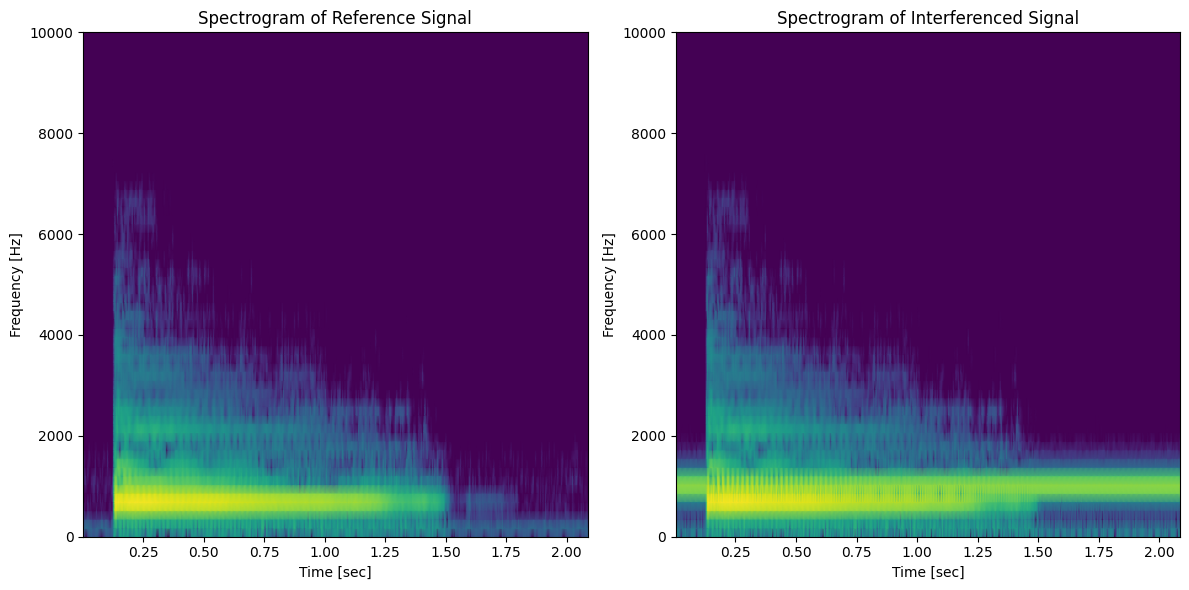

In [24]:
# Write your code here
import scipy.signal as sig
ff, tt, S_ref = sig.spectrogram(ref, fs=fs, window='hann')
ff_interf, tt_interf, S_interf = sig.spectrogram(x_interf, fs=fs, window='hann')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_spectrogram(ff, tt, S_ref)
plt.ylim(0, 10000)
plt.title('Spectrogram of Reference Signal')

plt.subplot(1, 2, 2)
plot_spectrogram(ff_interf, tt_interf, S_interf)
plt.ylim(0, 10000)
plt.title('Spectrogram of Interferenced Signal')

plt.tight_layout()
plt.show()

The spectrogram of the reference signal displays concentrated energy at lower frequencies around 500 Hz with higher intensity and a more complex structure, while the interference signal's spectrogram shows a persistent, lower-amplitude peak at 1000 Hz as a narrowband tone.

3.4. Create a function `remove_interference(x, fs)` that applies a nulling filter devised to remove the interference at 1000 Hz. 

Note: remember that a frequency can be converted to the normalized radian frequncy by: $\omega_n = 2\pi f_n/f_s$

In [25]:
def remove_interference(x, fs):

    f_n= 1000
    w_n = 2 * np.pi * f_n / fs  # normalized angular frequency
  
    b0 = 1
    b1 = -2 * np.cos(w_n)
    b2 = 1
    kernel = np.array([b0, b1, b2])
    
    y = np.convolve(x, kernel, mode='same')
  
    return y *5


3.5 Use the `remove_interference` funcion to clean the corrupted signal,  `x_interf`. Call the output as `x_clean`. Compare the spectrograms of both signals. Explain the result.

In [26]:
# Write your code here

cleaned_signal = remove_interference(x_interf, fs)

plot_signals([ref, cleaned_signal], fs, t_start, t_end, name=['ref', 'cleaned signal'])

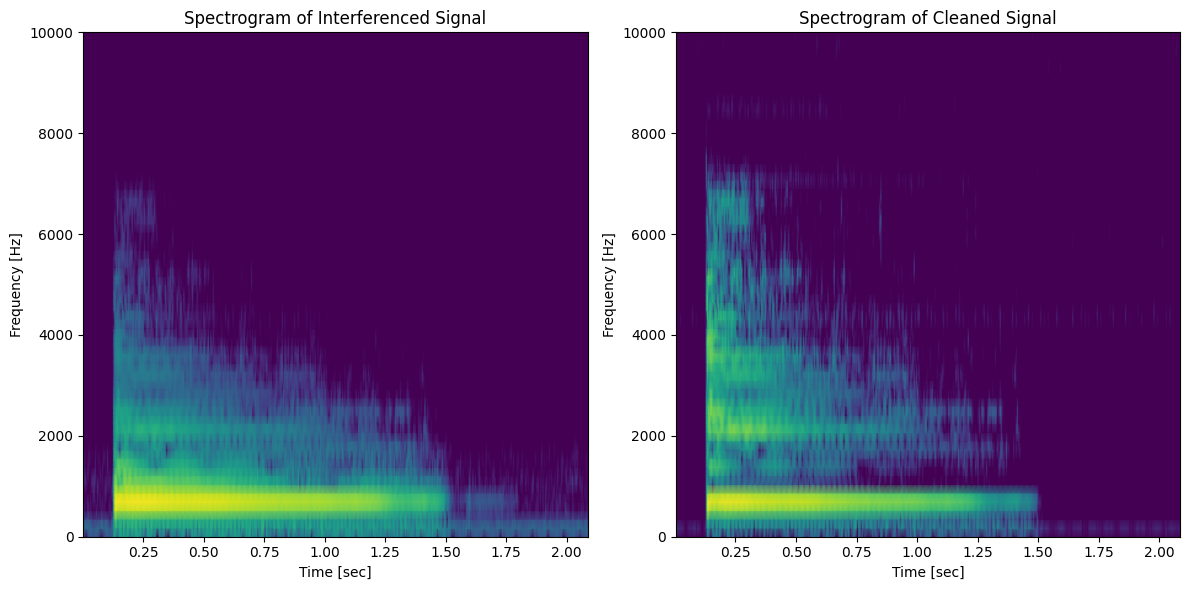

In [29]:
import scipy.signal as sig

ff_interf, tt_interf, S_interf = sig.spectrogram(x_interf, fs=fs, window='hann')

ff_cleaned, tt_cleaned, S_cleaned = sig.spectrogram(cleaned_signal, fs=fs, window='hann')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_spectrogram(ff, tt, S_ref)
plt.ylim(0, 10000)
plt.title('Spectrogram of Interferenced Signal')

plt.subplot(1, 2, 2)
plot_spectrogram(ff_cleaned, tt_cleaned, S_cleaned)
plt.ylim(0, 10000)
plt.title('Spectrogram of Cleaned Signal')

plt.tight_layout()
plt.show()





The spectrograms of the interferenced and cleaned signals both exhibit a dominant peak at 500 Hz with similar visual intensity due to the *5 scaling compensating for the notch filter's attenuation, while the cleaned version shows virtually no residual energy at 1000 Hz, confirming effective interference removal with the filter's kernel design.

In [28]:
import IPython.display as ipd

ipd.display(ipd.Audio(ref, rate=fs))
ipd.display(ipd.Audio(cleaned_signal, rate=fs))